In [1]:
import importlib

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import os
import kad.visualization.visualization as visualization
import kad.kad_utils.kad_utils as kad_utils
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.ts_analyzer.ts_analyzer as ts_analyzer
from kad.model import i_model, autoencoder_model, hmm_model, lstm_model
from kad.model import sarima_model
from sklearn.model_selection import train_test_split

kad_utils.customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython']


In [2]:
SARIMA_KEY: str = "SARIMA"
AUTOENCODER_KEY: str = "autoencoder"
HMM_KEY: str = "HMM"
LSTM_KEY: str = "LSTM"

ACC_KEY: str = "accuracy"
PREC_KEY: str = "precision"
RECALL_KEY: str = "recall"
AUROC_KEY: str = "auroc"

In [3]:

def downsampling_func(x: pd.DataFrame):
    """
    Values column is replaced with a mean, and labels are replaced by True if any of the labels
    in the original df was True
    :param x: part of dataframe to squash to one row
    :return: squashed pandas Series
    """
    values = x["value"].mean()

    labels = (x[kad_utils.GROUND_TRUTH_COLUMN]).any()

    return pd.Series([values, labels], index=["value", kad_utils.GROUND_TRUTH_COLUMN])

In [4]:
def perform_evaluation(evaluation_df: pd.DataFrame) -> dict:
    visualization.visualize(evaluation_df, metric_name="value")

    evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

    print("Accuracy: ", evaluator.get_accuracy())
    print("Avg precision: ", evaluator.get_average_precision())
    print("Recall: ", evaluator.get_recall_score())
    print("AU ROC: ", evaluator.get_auroc())

    return {ACC_KEY: evaluator.get_accuracy(),
            PREC_KEY: evaluator.get_average_precision(),
            RECALL_KEY: evaluator.get_recall_score(),
            AUROC_KEY: evaluator.get_auroc()}


In [5]:
def evaluate_sarima(p_preprocessed_df: pd.DataFrame) -> dict:
    values_df = p_preprocessed_df[["value"]]
    tsa = ts_analyzer.TsAnalyzer(values_df)
    dominant_freq = tsa.calculate_dominant_frequency()

    model: i_model.IModel = sarima_model.SarimaModel(order=(0, 0, 0), seasonal_order=(1, 0, 1, dominant_freq))

    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 18
    for i in range(0, len(test_df), samples_to_predict):
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    results_df = results_df.loc[test_df.index & results_df.index]

    return perform_evaluation(results_df)

In [6]:
def evaluate_autoencoder(p_preprocessed_df: pd.DataFrame) -> dict:
    model: i_model.IModel = autoencoder_model.AutoEncoderModel(time_steps=12)

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 60
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    results_df = results_df.loc[test_df.index & results_df.index]

    return perform_evaluation(results_df)

In [7]:
def evaluate_hmm(p_preprocessed_df: pd.DataFrame) -> dict:
    model: i_model.IModel = hmm_model.HmmModel()

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 5
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    results_df = results_df.loc[test_df.index & results_df.index]

    return perform_evaluation(results_df)

In [8]:
def evaluate_lstm(p_preprocessed_df: pd.DataFrame) -> dict:
    model: i_model.IModel = lstm_model.LstmModel(time_steps=12)

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 25
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    results_df = results_df.loc[test_df.index & results_df.index]

    return perform_evaluation(results_df)

art_daily_flatmiddle.csv
                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   35
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                  22.079
Date:                    Sun, 16 May 2021   AIC                            -38.157
Time:                            19:03:24   BIC                            -33.491
Sample:                                 0   HQIC                           -36.547
                                     - 35                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9999   5.46e-05   1.83e+04      0.000       1.000       1.000
ma.S.L24      74.5292   7.54e-10   9.88e+10      0.000      74.529      74

<ipython-input-5-d4dc5c00e30c>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.94
Avg precision:  0.49
Recall:  0.79
AU ROC:  0.76
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 32)             256       
_________________________________________________________________
dropout (Dropout)            (None, 6, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 16)             3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 6, 16)             1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 16)             0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 12, 32)            3616      
_________________________________________________________

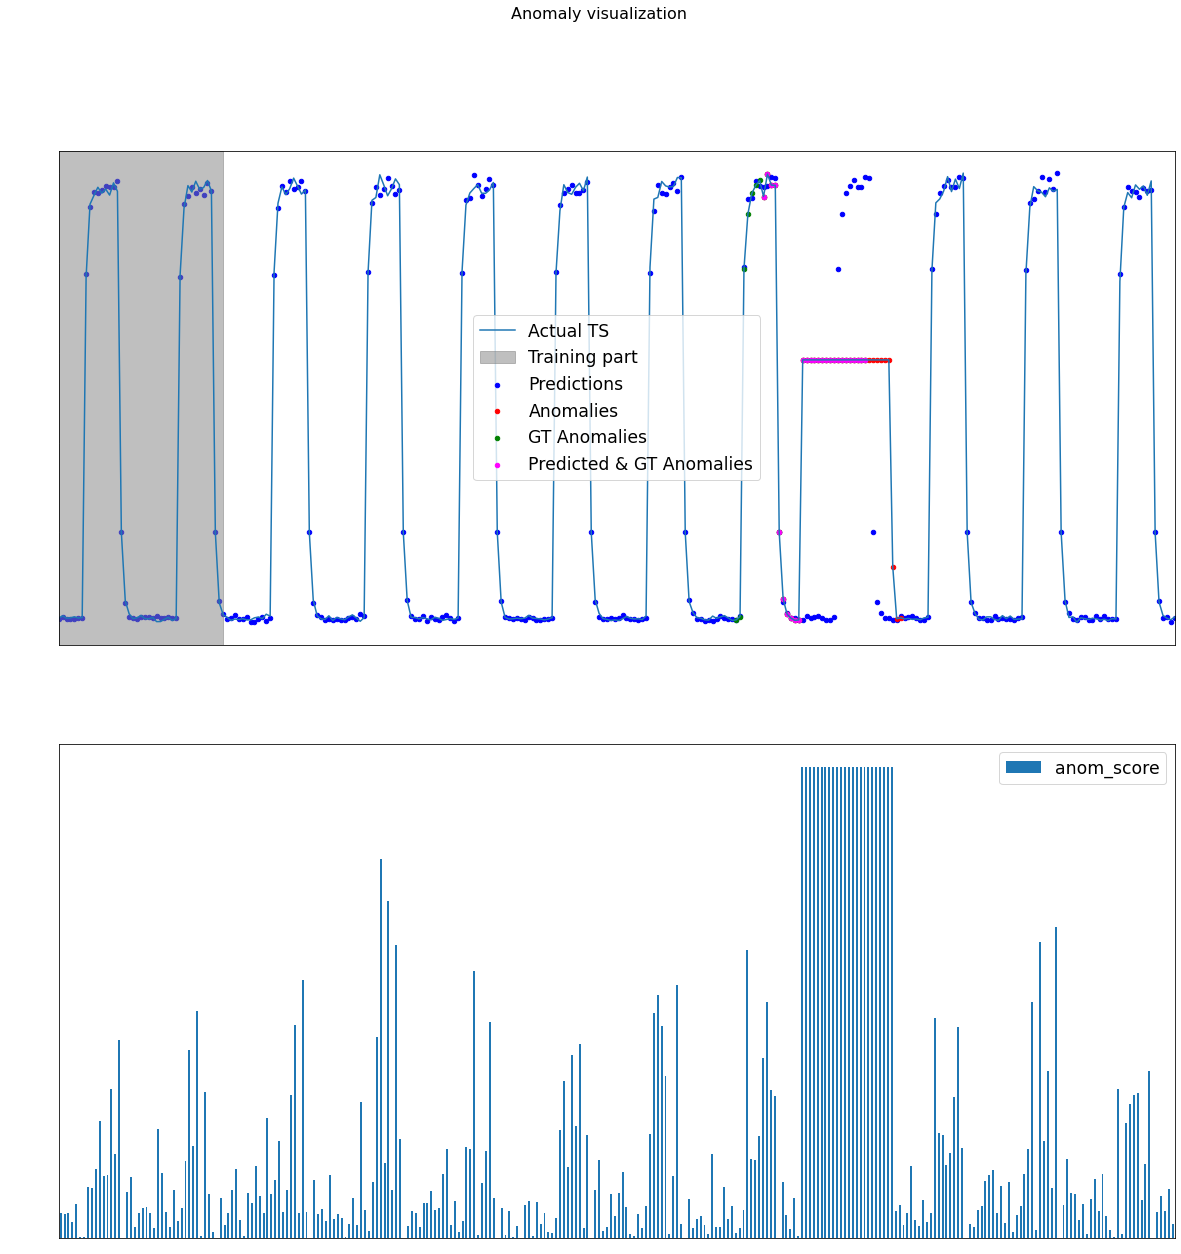

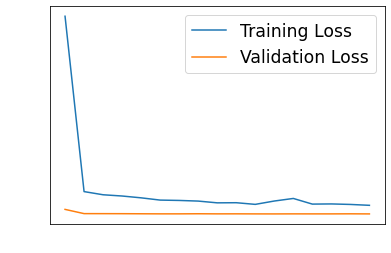

<ipython-input-6-07c0ddccccd0>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.88
Avg precision:  0.19
Recall:  0.0
AU ROC:  0.65


<ipython-input-7-094ee9036a38>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.82
Avg precision:  0.16
Recall:  0.59
AU ROC:  0.54
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 2s 385ms/step - loss: 0.2809 - val_loss: 0.3989
Epoch 2/50
2/2 [==============================] -

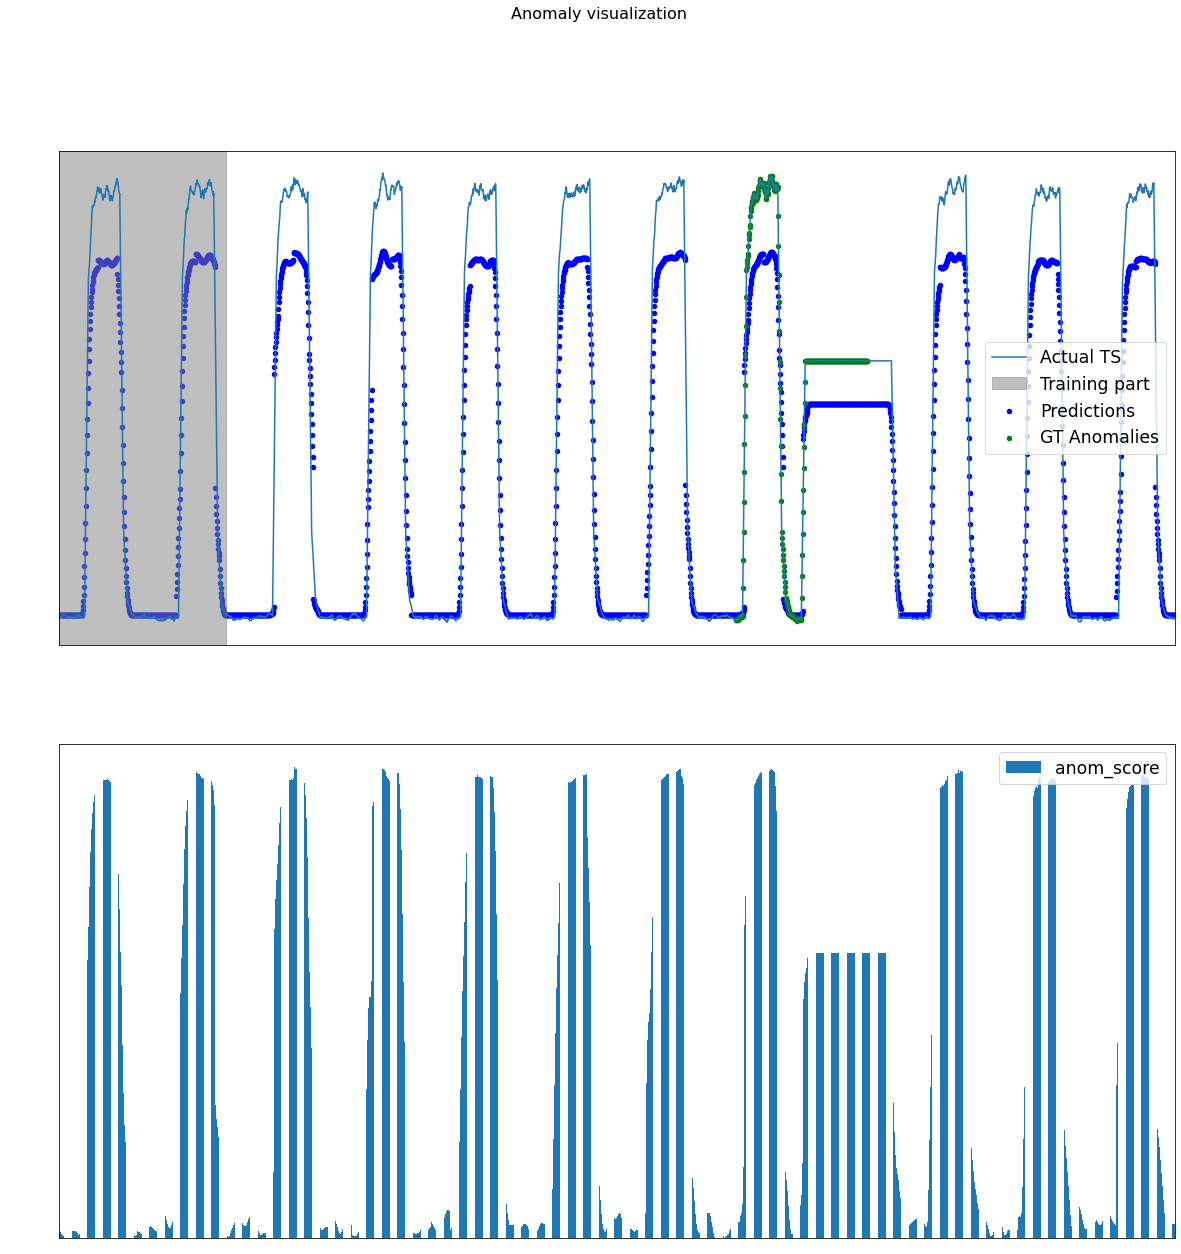

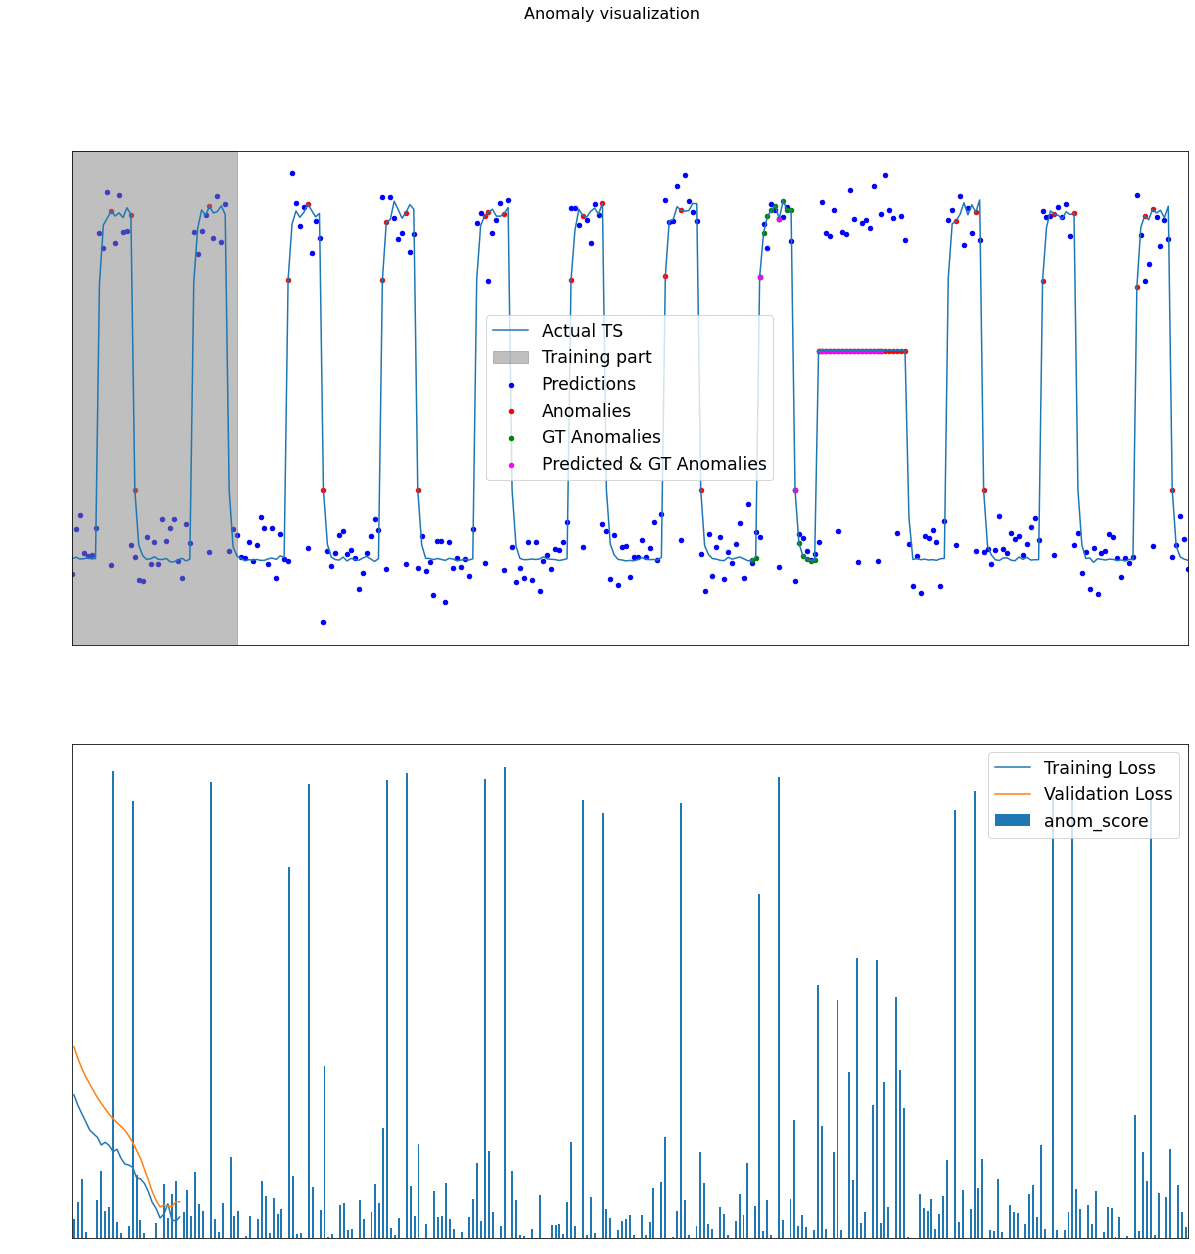

<ipython-input-8-f81d2d4f3101>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.86
Avg precision:  0.29
Recall:  0.12
AU ROC:  0.68
art_daily_jumpsdown.csv
                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   35
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                  10.406
Date:                    Sun, 16 May 2021   AIC                            -14.813
Time:                            19:04:00   BIC                            -10.147
Sample:                                 0   HQIC                           -13.202
                                     - 35                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9993      0.000   3195.290      0.000       0.999       1.000
ma.S.L24  

<ipython-input-5-d4dc5c00e30c>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.88
Avg precision:  0.36
Recall:  0.53
AU ROC:  0.6
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 6, 32)             256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 16)             3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 6, 16)             1808      
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 16)             0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 12, 32)            3616      
________________________________________________________

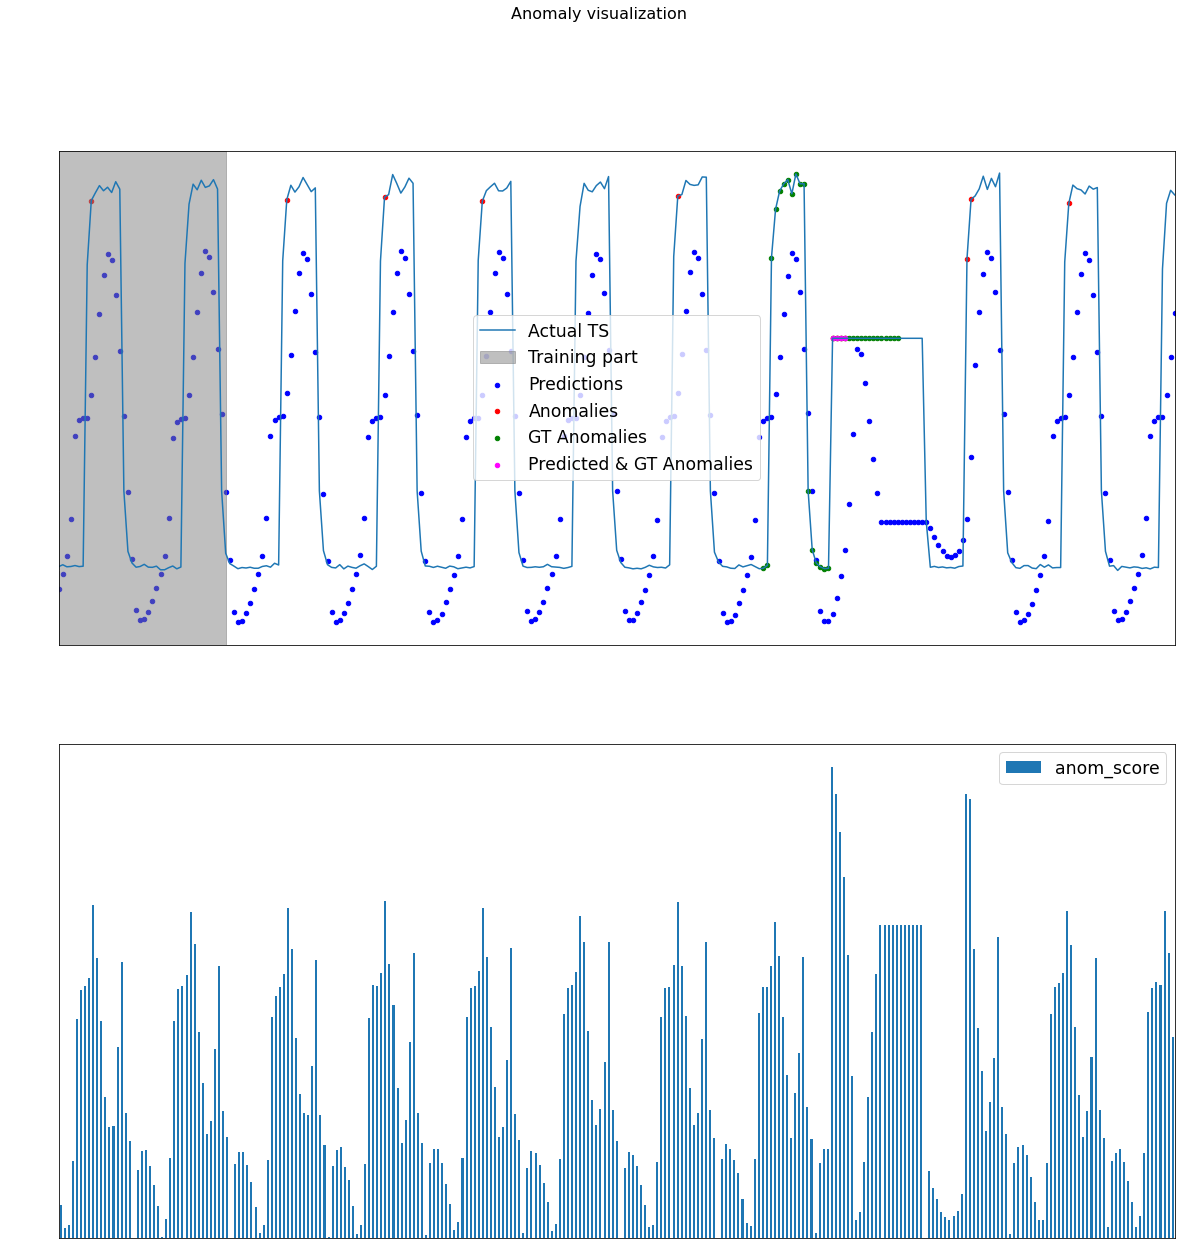

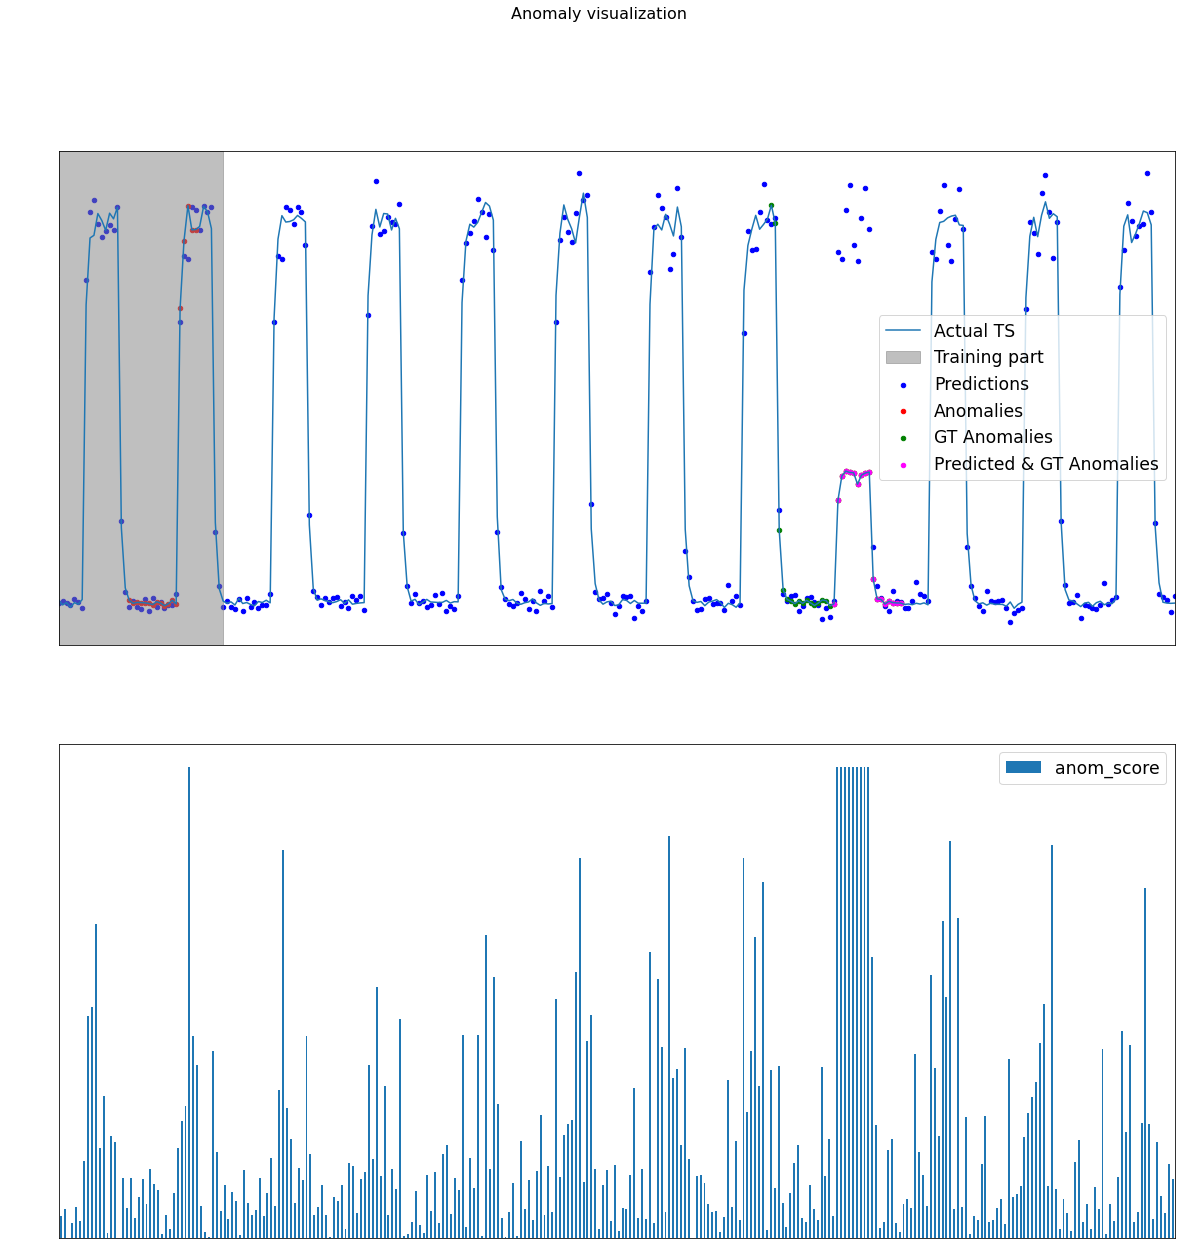

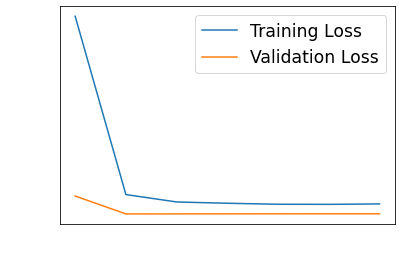

<ipython-input-6-07c0ddccccd0>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.88
Avg precision:  0.09
Recall:  0.0
AU ROC:  0.31


<ipython-input-7-094ee9036a38>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.82
Avg precision:  0.15
Recall:  0.26
AU ROC:  0.57
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 2s 422ms/step - loss: 0.3051 - val_loss: 0.3900
Epoch 2/50
2/2 [==============================] -

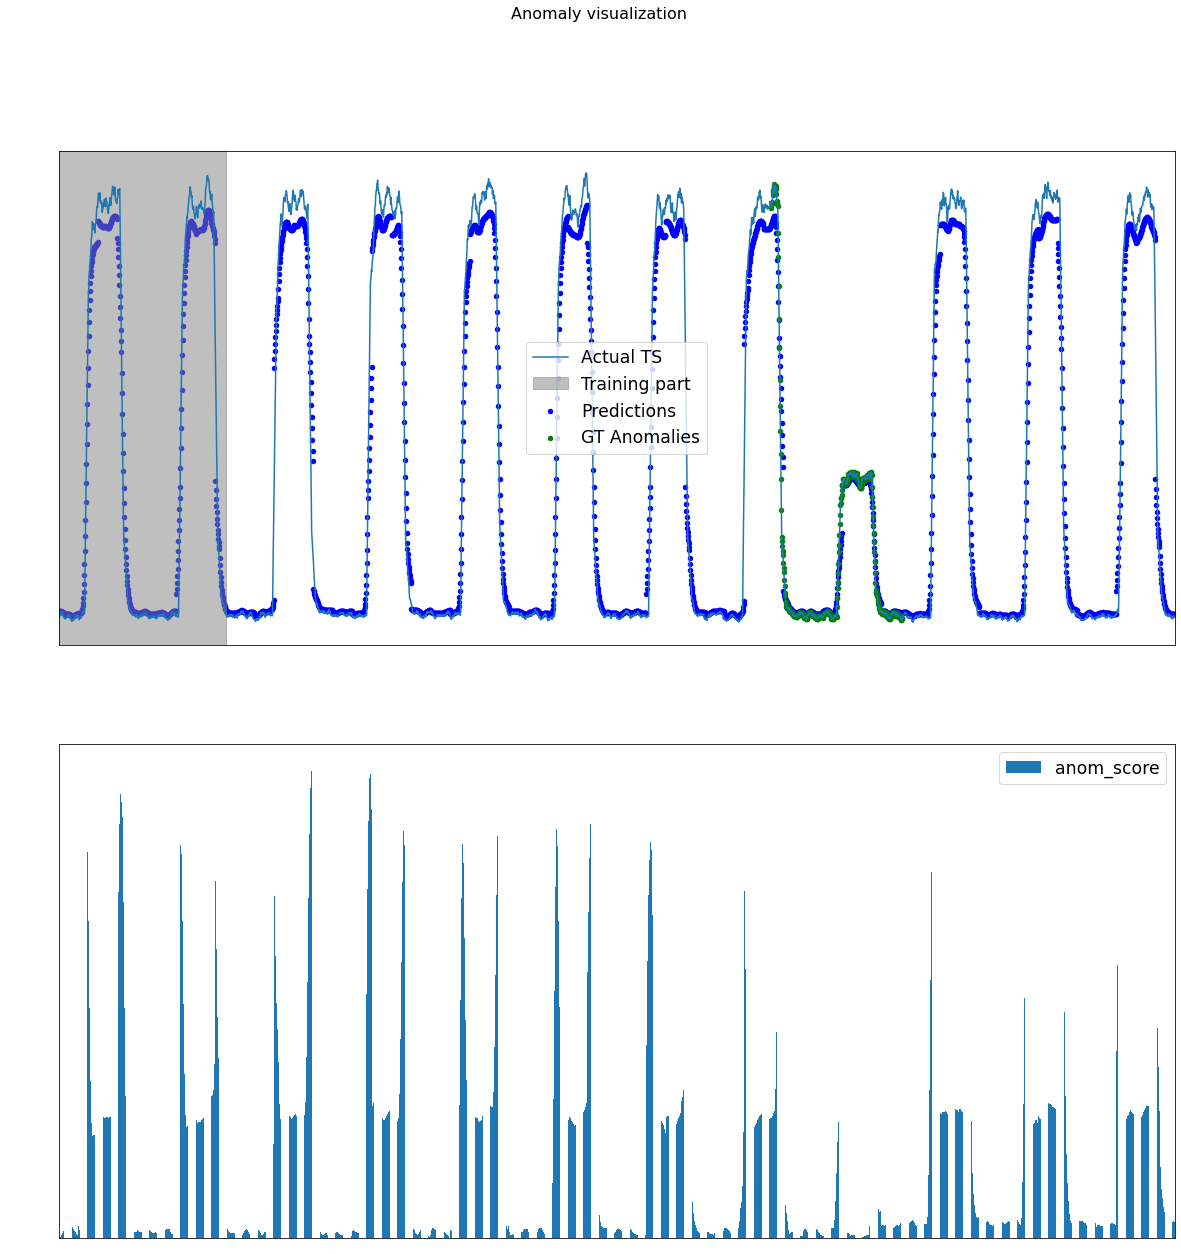

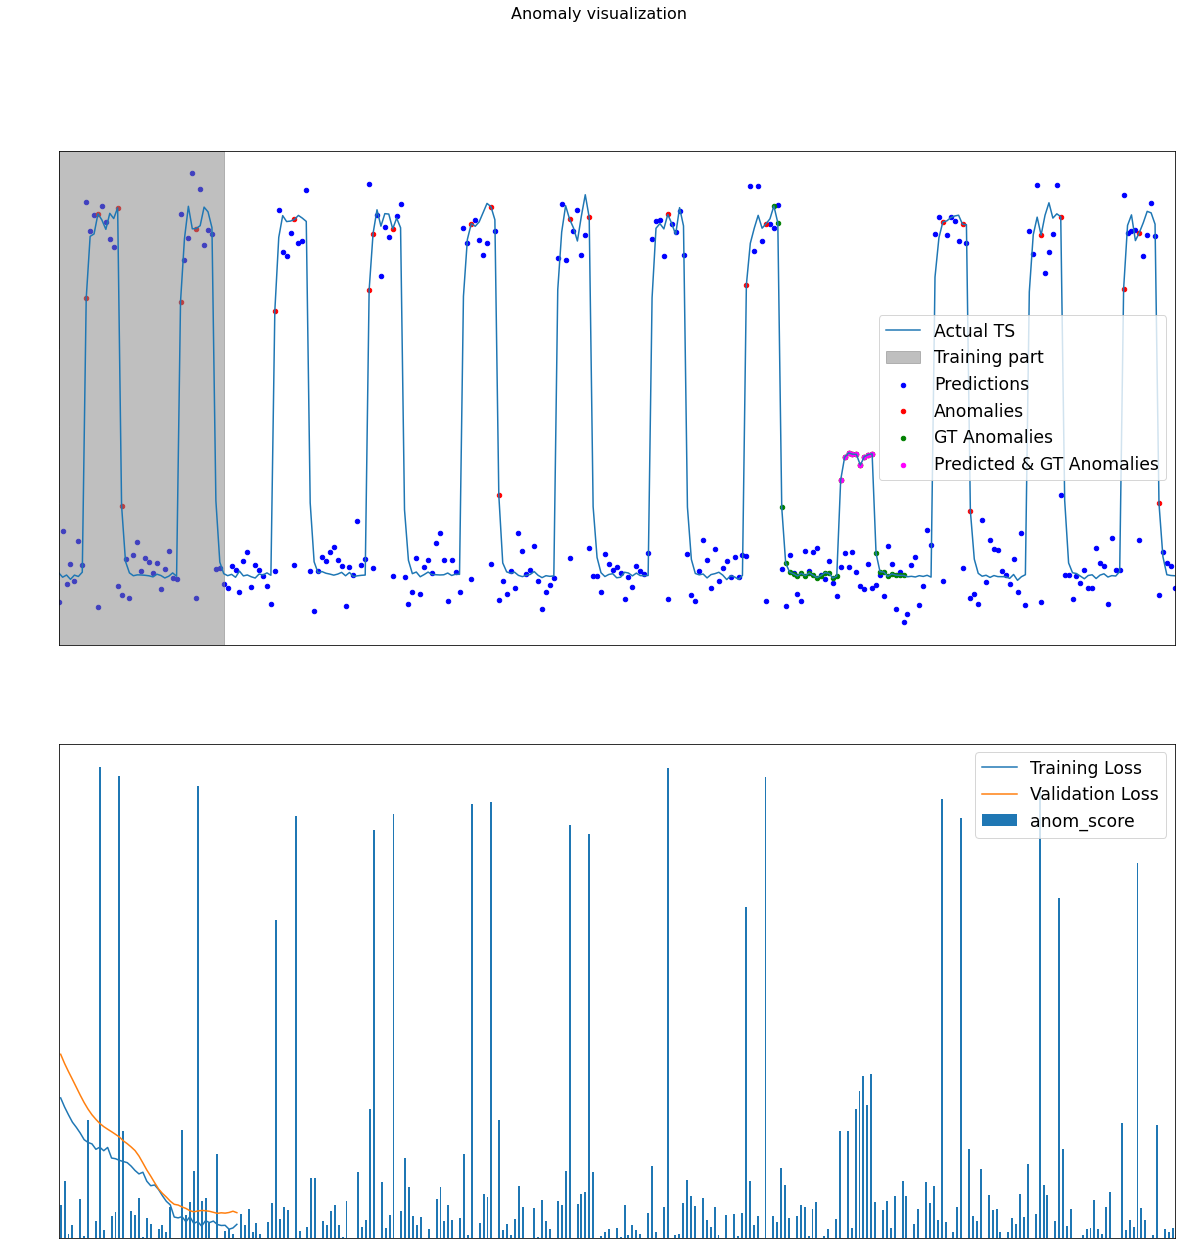

<ipython-input-8-f81d2d4f3101>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.87
Avg precision:  0.17
Recall:  0.0
AU ROC:  0.58
art_daily_nojump.csv
                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   35
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                  13.044
Date:                    Sun, 16 May 2021   AIC                            -20.088
Time:                            19:04:31   BIC                            -15.422
Sample:                                 0   HQIC                           -18.477
                                     - 35                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9996      0.000   3320.023      0.000       0.999       1.000
ma.S.L24      

<ipython-input-5-d4dc5c00e30c>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.7
Avg precision:  0.3
Recall:  0.53
AU ROC:  0.57
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 6, 32)             256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 32)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3, 16)             3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 6, 16)             1808      
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 16)             0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 12, 32)            3616      
_________________________________________________________

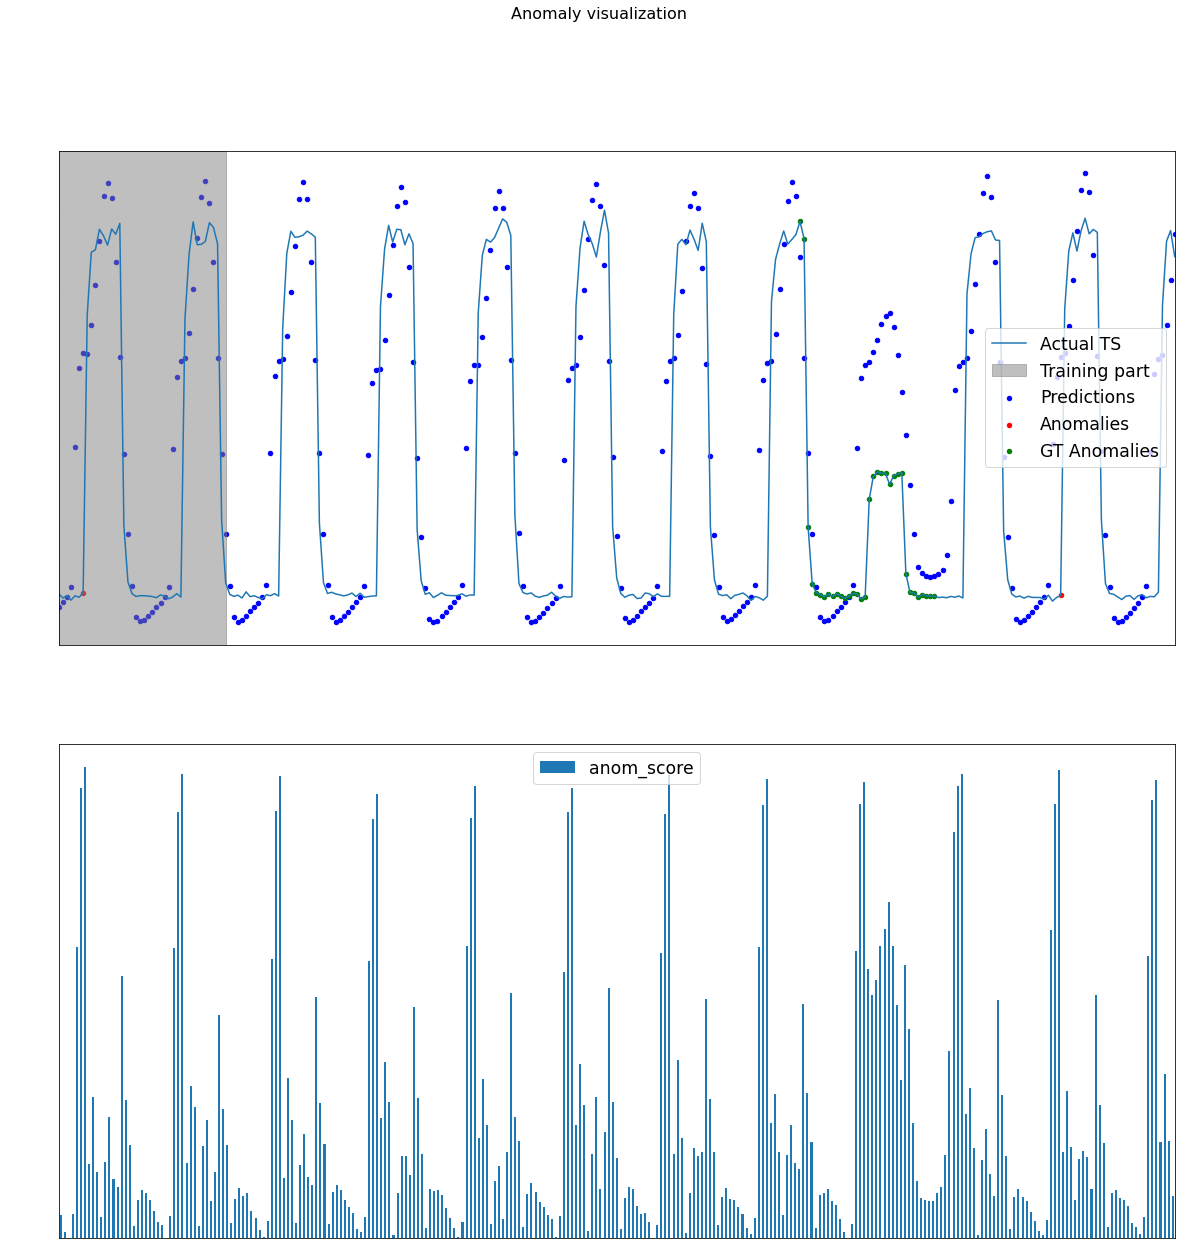

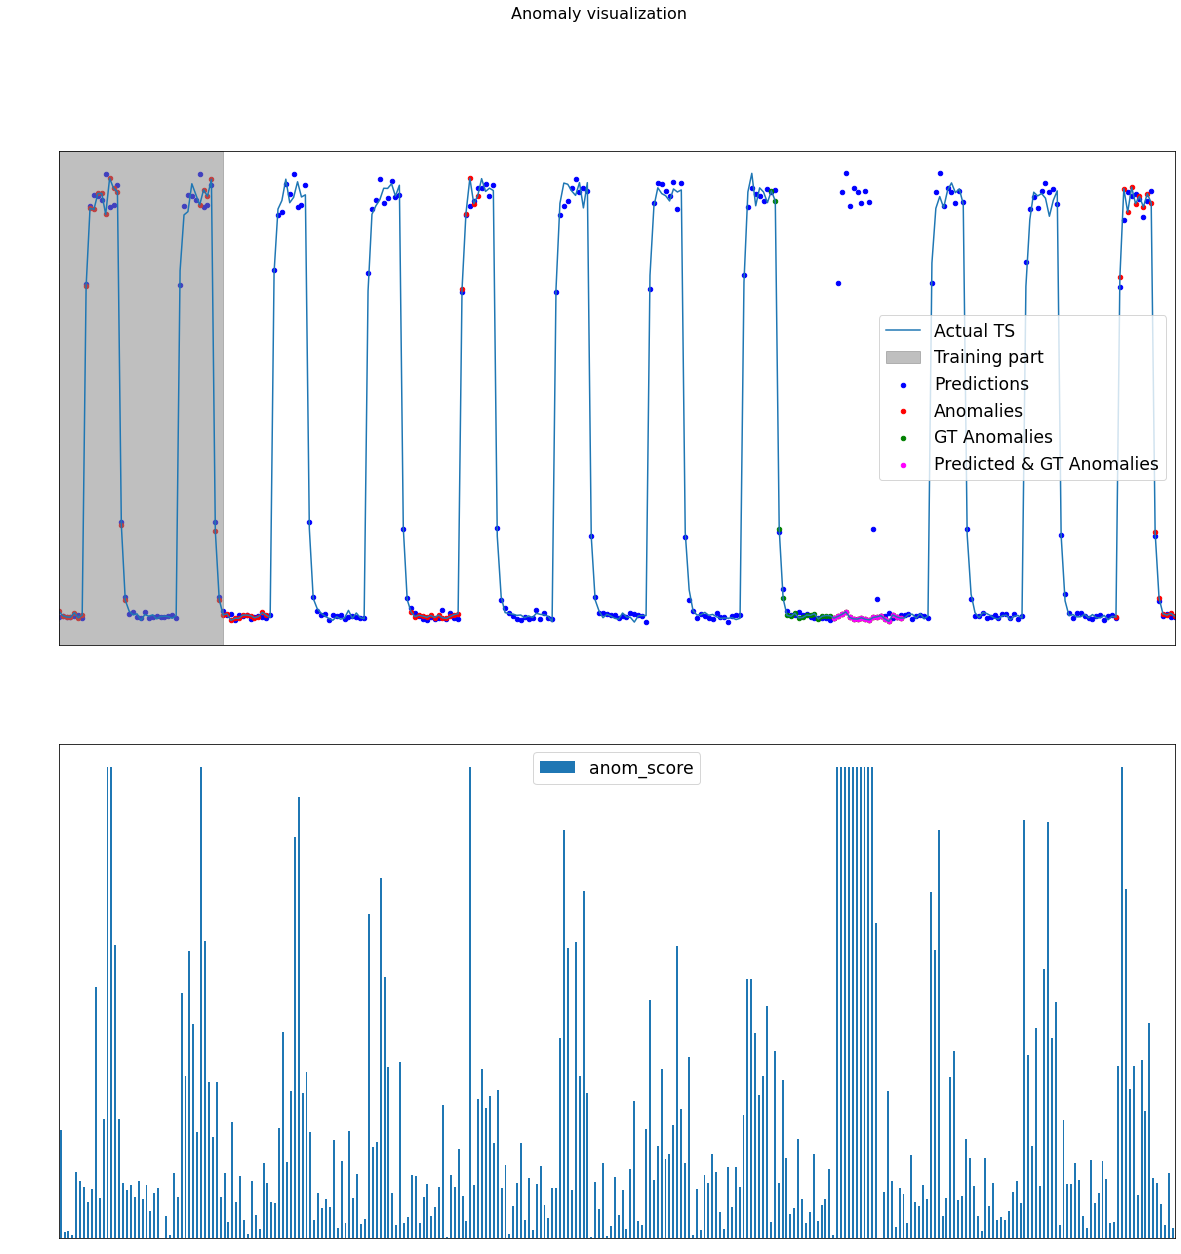

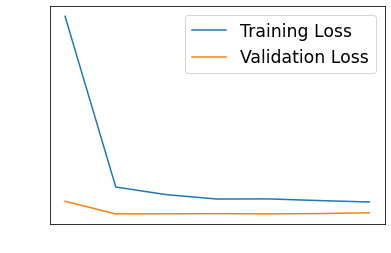

<ipython-input-6-07c0ddccccd0>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.88
Avg precision:  0.08
Recall:  0.0
AU ROC:  0.27


<ipython-input-7-094ee9036a38>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.8
Avg precision:  0.1
Recall:  0.0
AU ROC:  0.44
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 2s 359ms/step - loss: 0.3270 - val_loss: 0.4004
Epoch 2/50
2/2 [==============================] - 0s

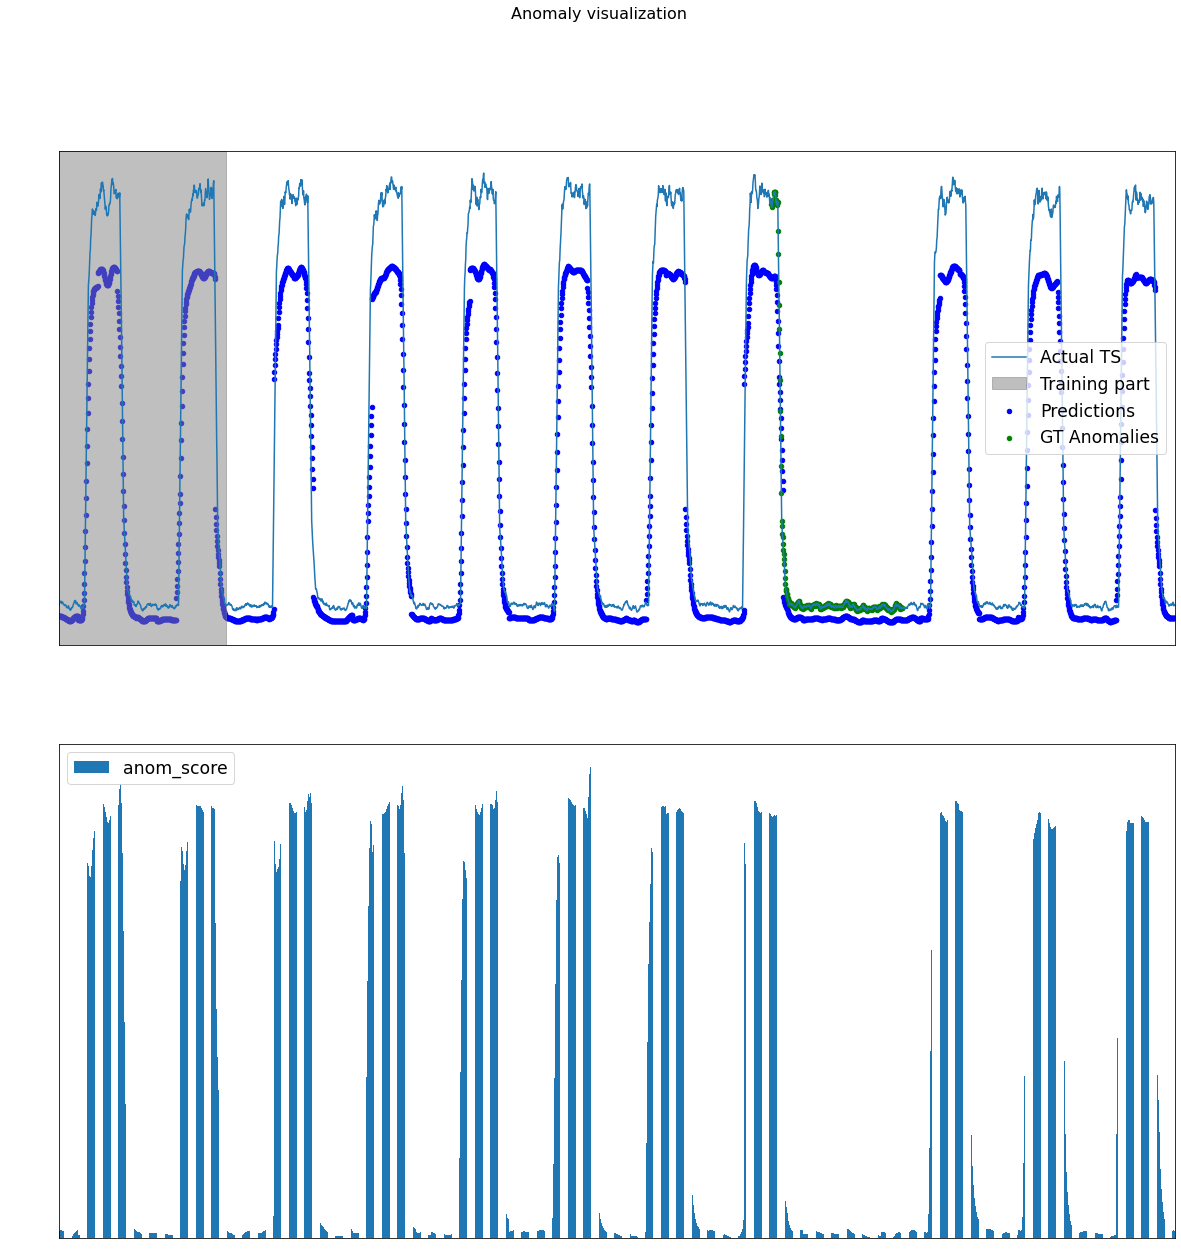

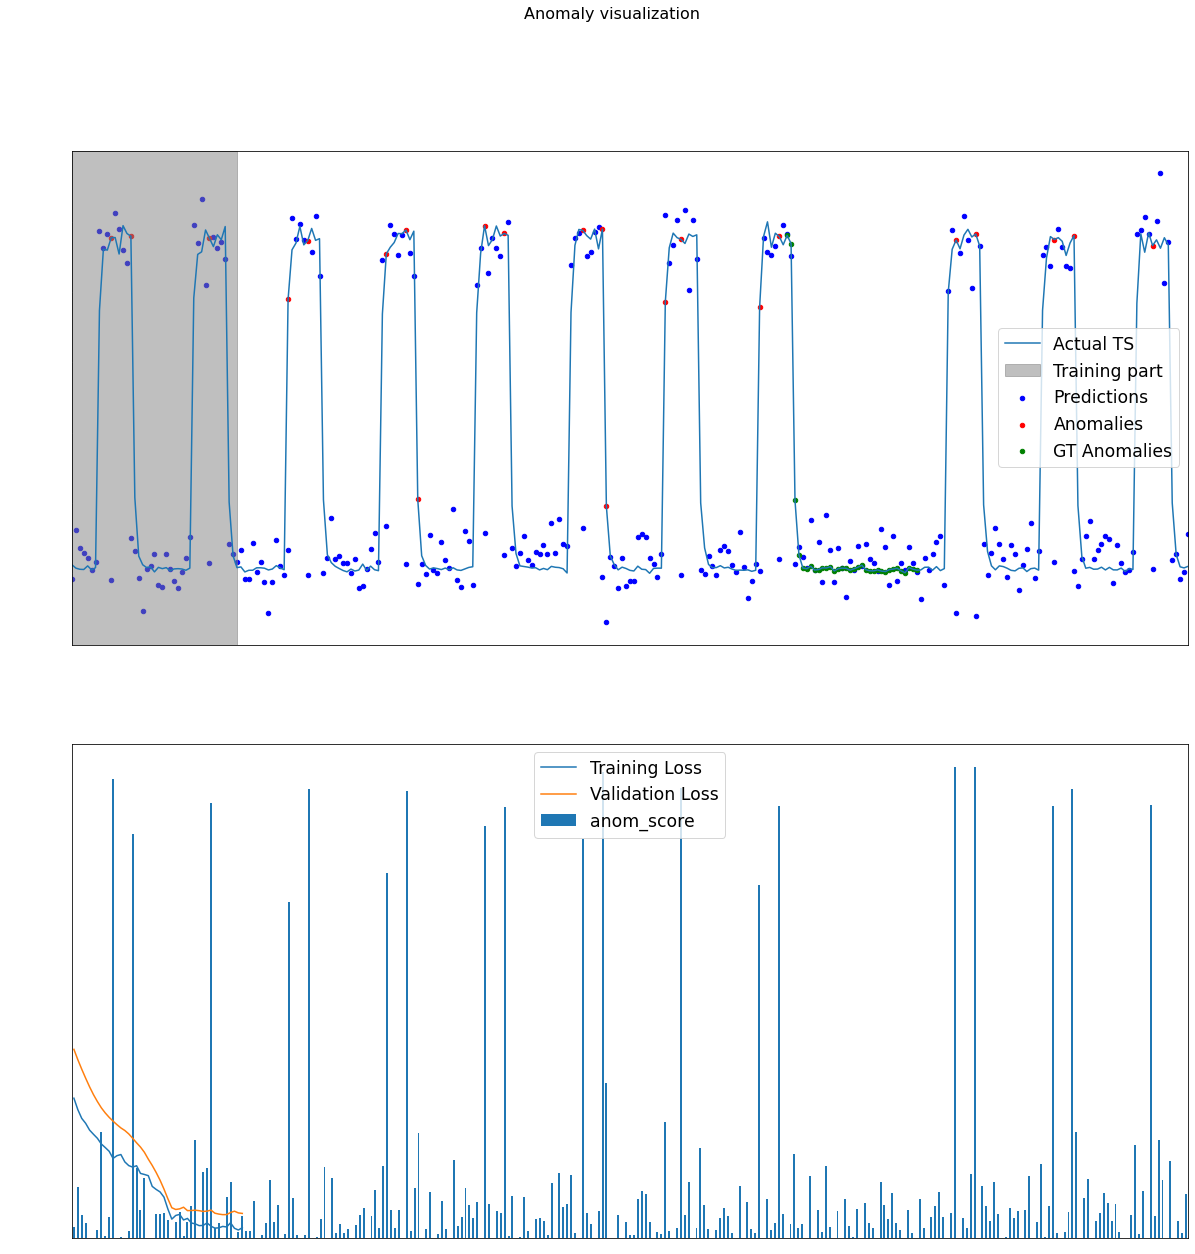

<ipython-input-8-f81d2d4f3101>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.87
Avg precision:  0.21
Recall:  0.0
AU ROC:  0.67
art_daily_jumpsup.csv
                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   35
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                  41.509
Date:                    Sun, 16 May 2021   AIC                            -77.019
Time:                            19:04:59   BIC                            -72.353
Sample:                                 0   HQIC                           -75.408
                                     - 35                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9998      0.000   7690.852      0.000       1.000       1.000
ma.S.L24     

<ipython-input-5-d4dc5c00e30c>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.87
Avg precision:  0.41
Recall:  1.0
AU ROC:  0.66
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 6, 32)             256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 6, 32)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3, 16)             3600      
_________________________________________________________________
conv1d_transpose_9 (Conv1DTr (None, 6, 16)             1808      
_________________________________________________________________
dropout_10 (Dropout)         (None, 6, 16)             0         
_________________________________________________________________
conv1d_transpose_10 (Conv1DT (None, 12, 32)            3616      
________________________________________________________

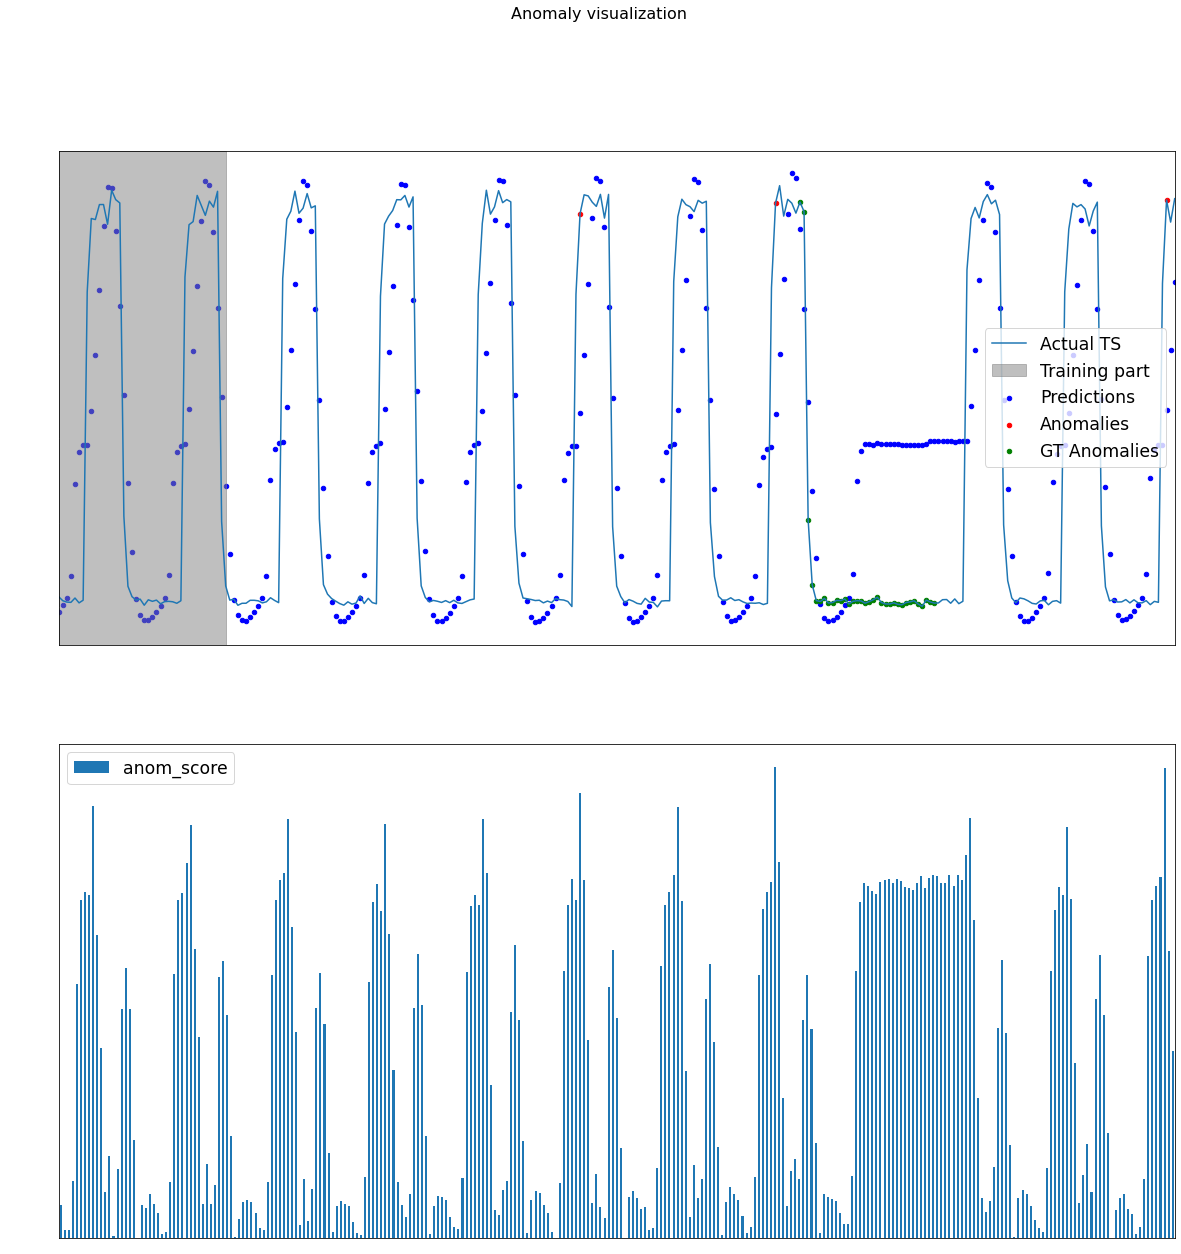

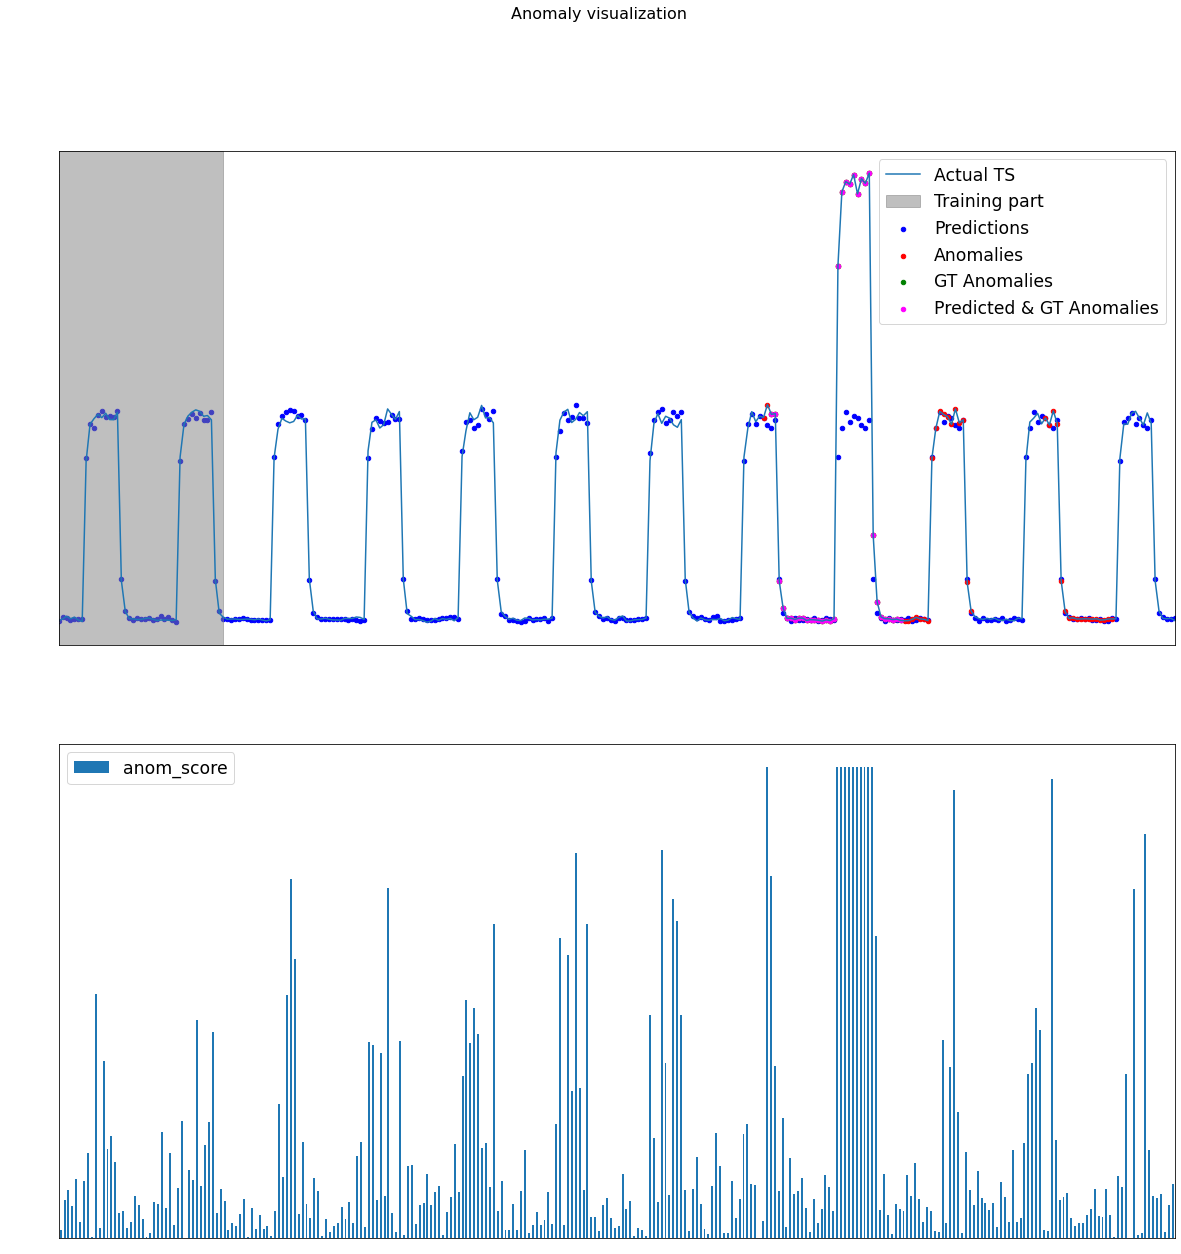

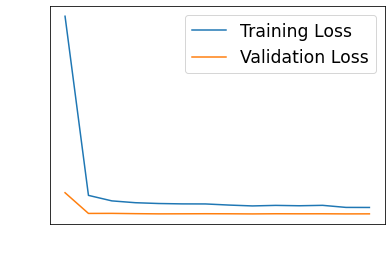

<ipython-input-6-07c0ddccccd0>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.88
Avg precision:  0.27
Recall:  0.0
AU ROC:  0.58


<ipython-input-7-094ee9036a38>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.85
Avg precision:  0.28
Recall:  0.29
AU ROC:  0.62
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 2s 201ms/step - loss: 0.0736 - val_loss: 0.0881
Epoch 2/50
2/2 [==============================] -

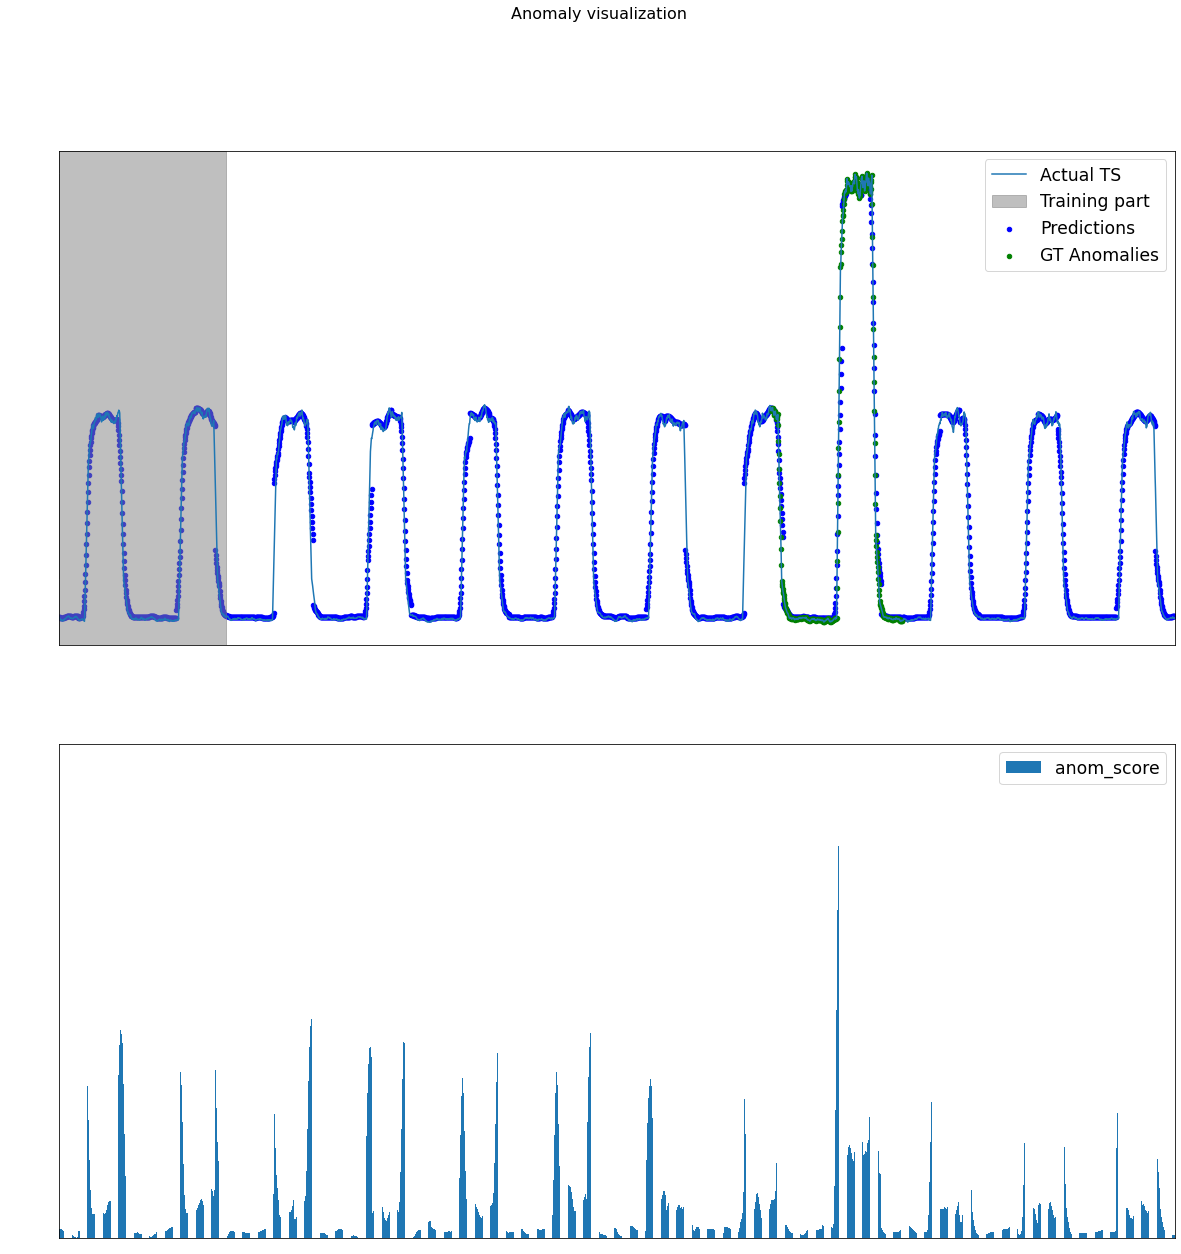

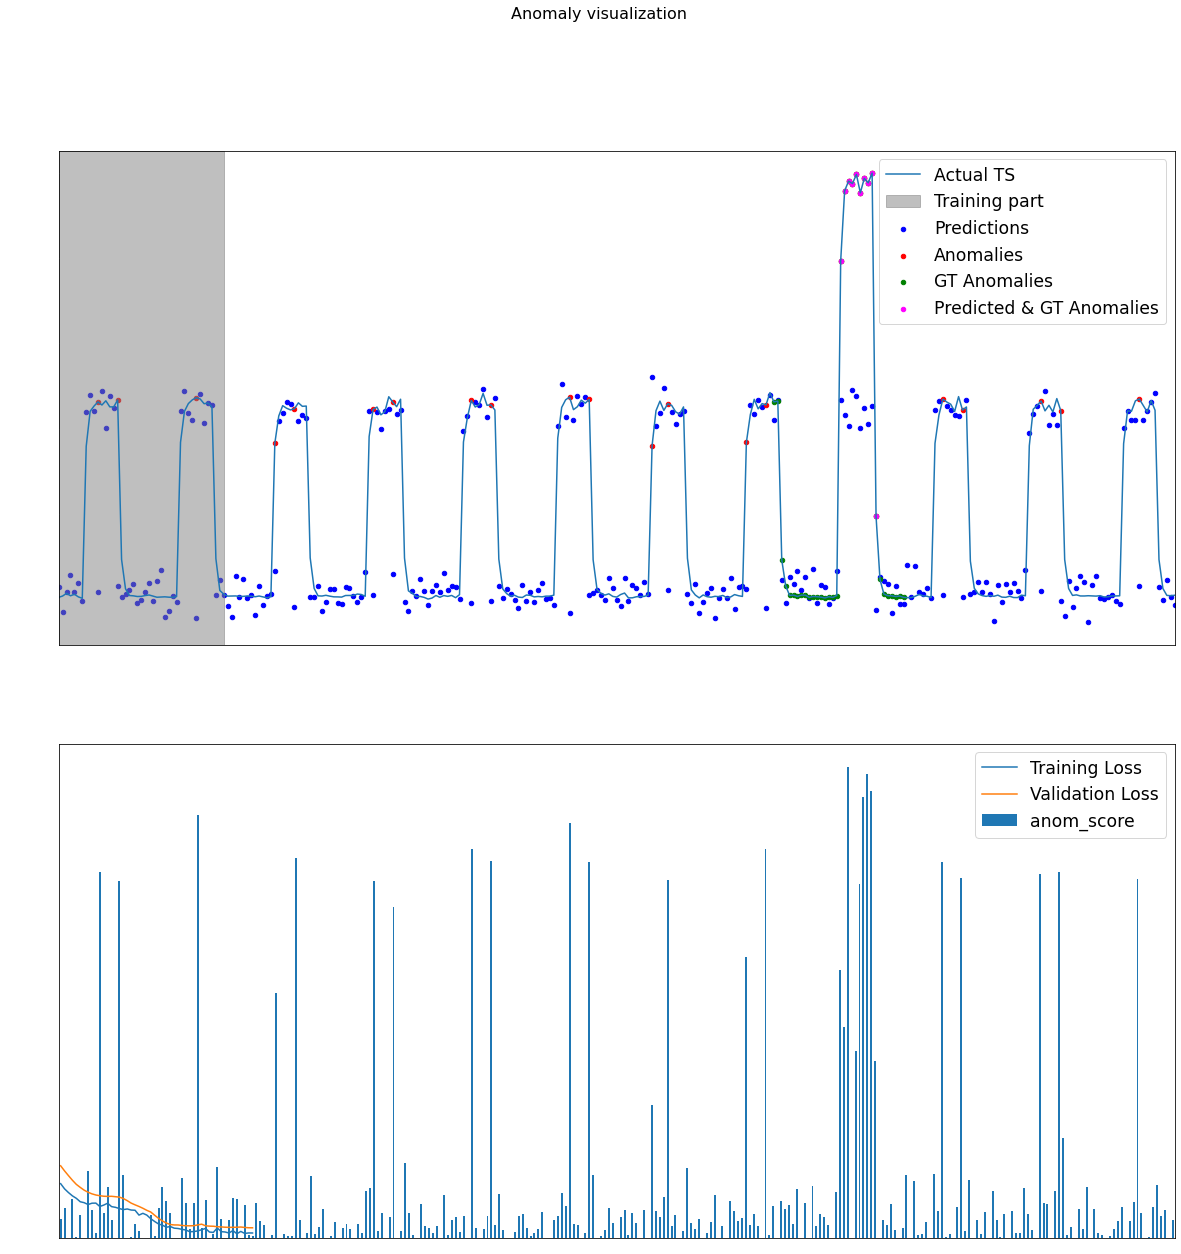

<ipython-input-8-f81d2d4f3101>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.9
Avg precision:  0.53
Recall:  0.38
AU ROC:  0.72


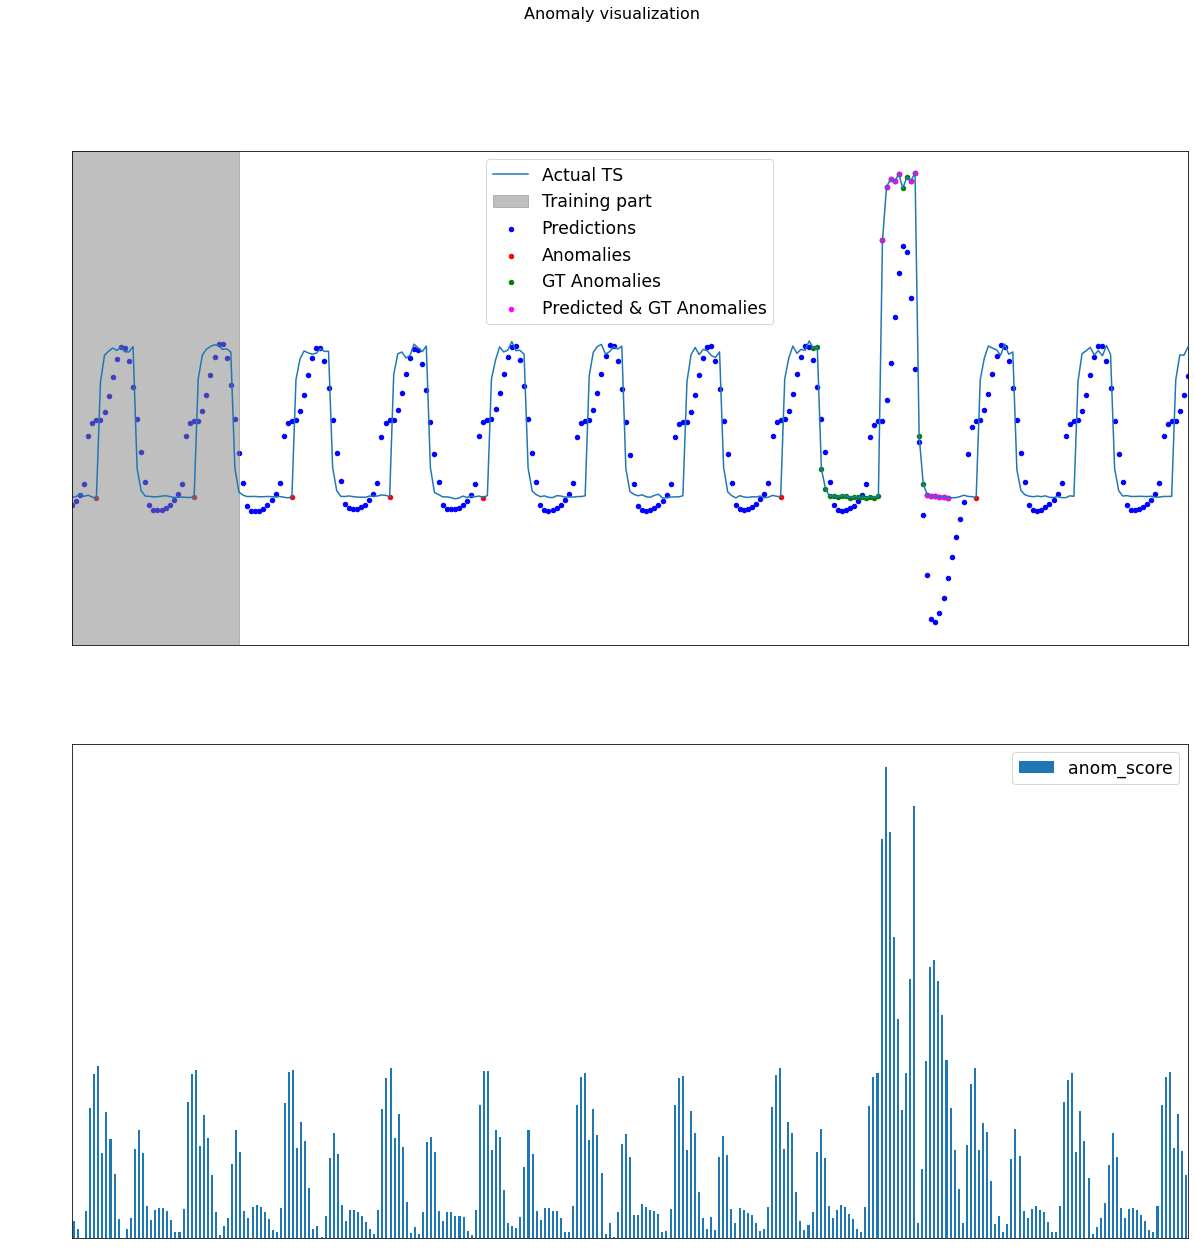

In [9]:
eval_dict: dict = {}

X_LABEL = "timestamp"
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"

with open("data/archive/combined_windows.json") as f:
    ground_true_anomalies = json.load(f)

files_to_eval = ["art_daily_flatmiddle.csv",
                 "art_daily_jumpsdown.csv",
                 "art_daily_nojump.csv",
                 "art_daily_jumpsup.csv"]

for (dirpath, dirnames, filenames) in os.walk(data_dir):
    for filename in filenames:
        if filename in files_to_eval:
            file_path = os.path.join(dirpath, filename)

            print(filename)
            eval_dict[filename] = {}

            original_df = pd.read_csv(
                file_path, parse_dates=True, index_col="timestamp"
            )

            true_anomalies_ranges = ground_true_anomalies["/".join(file_path.split("/")[-2:])]
            ground_true_anomalies_df = pd.DataFrame()
            for anom_range in true_anomalies_ranges:
                ground_true_anomalies_df = ground_true_anomalies_df.append(
                    original_df.loc[anom_range[0]:anom_range[1]])
            original_df[kad_utils.GROUND_TRUTH_COLUMN] = [idx in ground_true_anomalies_df.index for idx in
                                                          original_df.index.tolist()]
            # SARIMA
            preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
            scaler = MinMaxScaler(feature_range=(0, 1))
            preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

            sarima_results = evaluate_sarima(preprocessed_df)
            eval_dict[filename][SARIMA_KEY] = sarima_results

            # AUTOENCODER
            preprocessed_df = original_df.copy()
            preprocessed_df["value"] = preprocessed_df["value"].rolling("h").sum()
            scaler = MinMaxScaler(feature_range=(0, 1))
            preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

            autoencoder_results = evaluate_autoencoder(preprocessed_df)
            eval_dict[filename][AUTOENCODER_KEY] = autoencoder_results

            # HMM
            preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
            scaler = MinMaxScaler(feature_range=(0, 1))
            preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

            hmm_results = evaluate_hmm(preprocessed_df)
            eval_dict[filename][HMM_KEY] = hmm_results

            # LSTM
            preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
            scaler = MinMaxScaler(feature_range=(0, 1))
            preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

            lstm_results = evaluate_lstm(preprocessed_df)
            eval_dict[filename][LSTM_KEY] = lstm_results

In [10]:
eval_json = "eval.json"

with open(eval_json, "w") as fp:
    json.dump(eval_dict, fp)
